In [ ]:
import warnings
warnings.filterwarnings("ignore", message="networkx backend defined more than once")
import sys
import gc
import os
import csv
import copy
import json
import math
import shutil
import random
import pickle
import itertools
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from protocols import MPC_protocol, MPG_protocol, SP_protocol
from graph import network, set_p_edge

from joblib import Parallel, delayed
from itertools import product
from networkx.algorithms.community import greedy_modularity_communities
from networkx.drawing.layout import *

# 获取当前 Notebook 的绝对路径
notebook_path = os.path.abspath("")
from config import DATA_PATHS



In [ ]:
mkr = ['x','+','d','o','1','2']+['x']*100
dashs = ['-.','--',':','-']+['-']*100
cols = ['gray','g','b','orange','r','k','purple']+['k']*100
linewidth = 2.2
mks = 5.5
fontsize = 14
sys.path.append("..")  # 确保根目录在 Python 路径中
root_path = DATA_PATHS["input_graphs"]
LOOP_STATE_PATH = "loop_state1.pkl"
TEMP_DATA_PATH = "temp_data.pkl"

Find the ER for the MPC, MPG, and SP protocols

In [ ]:
def load_data(filepath):
    pos = {}
    user = []

    # Step 1: 读取 JSON 文件
    with open(filepath, "r") as f:
        data = json.load(f)

    # Step 2: 初始化图
    G = nx.Graph()

    # Step 3: 添加节点

    for node in data["nodes"]:
        node_id = node["id"]
        x, y = node["latitude"], node["longitude"]
        G.add_node(node_id, location=node["location"], country=node["country"])  # 添加节点到图
        pos[node_id] = (y, x)  # 保存节点位置，注意 (longitude, latitude)

    # Step 4: 添加边
    for edge in data["links"]:
        source = int(edge["source"])
        target = int(edge["target"])
        G.add_edge(source, target, length=edge["length"])  # 添加边到图

    degree_dict = dict(G.degree())
    degree_items = list(degree_dict.items())
    first_node,first_degree = degree_items[0]
    print(f"First node ID: {first_node}, Degree: {first_degree}")

    user.append(data["nodes"][0]["id"])

    return G,user,pos

In [ ]:
def multi_iterative_score_partition_with_drawing(
    G, 
    fixed_node, 
    alpha=1.0, 
    beta=1.0,
    max_rounds=10,
    shuffle_nodes=True,
    pos=None,
    output_path=None,
    sample_size=100  # 新增参数，默认只取 100 组组合
):
    """
    多轮迭代版“打分 + 搬家”分社区并筛选出 100 个组合：
      - 社区数 = degree(fixed_node) + 1
      - 初始: 0 号社区放 fixed_node，其余邻居各占一社区
      - 分配时: score = alpha * distance + beta * community_size
      - 多轮: 若搬家能让节点的 score 更低，则搬家，直至收敛或达到 max_rounds
      - 只随机返回 100 个组合，以防止组合数过多导致 MemoryError

    返回：
      - 最终的社区划分 communities
      - 100 个 key_nodes 组合列表
    """
    
    # ============ 1) 初始化社区容器 ============
    neighbors = list(G.neighbors(fixed_node))
    num_communities = len(neighbors)  # 除 0 号社区外的社区数
    communities = [set() for _ in range(num_communities + 1)]
    visited = set()

    # 第 0 号社区放 fixed_node
    communities[0].add(fixed_node)
    visited.add(fixed_node)

    # 其余邻居各占一社区
    for i, nb in enumerate(neighbors, start=1):
        communities[i].add(nb)
        visited.add(nb)

    # ============ 2) 初次分配剩余节点 ============
    for node in G.nodes():
        if node not in visited:
            best_score = float('inf')
            best_index = None
            # 尝试放入各社区，选择 score 最低者
            for i, nb in enumerate(neighbors, start=1):
                dist = nx.shortest_path_length(G, source=node, target=nb)
                size = len(communities[i])
                score = alpha * dist + beta * size
                if score < best_score:
                    best_score = score
                    best_index = i
            communities[best_index].add(node)
            visited.add(node)

    # ============ 3) 多轮迭代搬家 ============
    round_num = 0
    while round_num < max_rounds:
        round_num += 1
        moved_count = 0

        # 获取除 fixed_node 外的所有节点
        all_nodes = [n for n in G.nodes() if n != fixed_node]

        if shuffle_nodes:
            random.shuffle(all_nodes)

        for node in all_nodes:
            # 找到当前所在社区
            current_idx = None
            for i, comm in enumerate(communities):
                if node in comm:
                    current_idx = i
                    break
            
            # 固定节点不搬家
            if current_idx == 0:
                continue

            # 当前社区 score
            nb_current = neighbors[current_idx - 1]  # 对应邻居
            dist_current = nx.shortest_path_length(G, source=node, target=nb_current)
            size_current = len(communities[current_idx])
            current_score = alpha * dist_current + beta * size_current

            # 尝试搬家到其他社区
            best_score = current_score
            best_index = current_idx

            for i, nb in enumerate(neighbors, start=1):
                if i == current_idx:
                    continue
                dist = nx.shortest_path_length(G, source=node, target=nb)
                size = len(communities[i])
                score = alpha * dist + beta * size

                if score < best_score:
                    best_score = score
                    best_index = i

            # 若找到更优的社区，则搬家
            if best_index != current_idx:
                communities[current_idx].remove(node)
                communities[best_index].add(node)
                moved_count += 1

        # 若无人搬家，则收敛，退出迭代
        if moved_count == 0:
            break

    # ============ 4) 生成 key_nodes 组合 ============
    # 注意：0 号社区仅包含 fixed_node，不参与组合枚举
    all_key_nodes_combos = []
    if all(len(communities[i]) > 0 for i in range(1, num_communities + 1)):
        # 计算所有组合总数
        total_combos = 1
        for i in range(1, num_communities + 1):
            total_combos *= len(communities[i])

        # 随机采样 100 个组合（如果组合数少于 100，则返回所有组合）
        if total_combos <= sample_size:
            all_products = product(*(communities[i] for i in range(1, num_communities + 1)))
            for combo in all_products:
                combo_list = [fixed_node] + list(combo)
                all_key_nodes_combos.append(combo_list)
        else:
            # 随机选择 100 个组合
            sampled_set = set()
            while len(all_key_nodes_combos) < sample_size:
                combo = tuple(random.choice(tuple(communities[i])) for i in range(1, num_communities + 1))
                if combo not in sampled_set:
                    sampled_set.add(combo)
                    all_key_nodes_combos.append([fixed_node] + list(combo))
    else:
        all_key_nodes_combos = []

    return communities, all_key_nodes_combos


In [ ]:

def plot_er_vs_p(p_range, ER, funcs, cols, output_path, fontsize=12, figsize=(10, 6), dpi=600):
    """
    绘制 ER 与链接生成概率 p 的关系图，并保存为文件。

    参数:
        p_range (array-like): p 的取值范围。
        ER (list of lists): 每个函数对应的 ER 数据。
        funcs (list): 包含函数的列表，用于生成图例名称。
        cols (list): 每个函数对应的颜色列表。
        output_path (str): 保存图片的路径。
        fontsize (int, 可选): 坐标轴和标签字体大小，默认 12。
        figsize (tuple, 可选): 图形大小，默认 (10, 6)。
        dpi (int, 可选): 图像分辨率，默认 600。
    """
    nom_list = [str(f).split(' ')[1] for f in funcs]
    plt.figure(figsize =(10,6),dpi=600 )
    plt.grid(linewidth=0.5)
    for i in range(len(funcs)):
        y = plt.plot(p_range, ER[i],
                    color = cols[i],
                    marker = "x",
                    linestyle='None',
                    markersize = 3,
                    #  alpha = 0.5,
                    #  linewidth=linewidth,
                    label = nom_list[i])
    plt.yscale('log')
    plt.legend(fontsize=10)
    plt.tick_params(labelsize=fontsize)

    plt.xlabel('Link generation probability p',fontsize=fontsize)
    plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)',fontsize=fontsize)

    ax = plt.gca()
    ax.set_xlim([0.2, 1])
    ax.set_ylim([0.0001, 1])
    # 保存图片
    plt.savefig(output_path, dpi=dpi)
    plt.close('all')
    print(f"Plot saved to {output_path}")

In [ ]:
def process_single_p(G, combo, p, funcs, timesteps, reps):
    """处理单个p值的并行任务函数"""
    local_G = G.copy()
    # 设置当前p值的边概率
    set_p_edge(local_G, p_op=p)
    
    # 为所有协议计算当前p的ER值
    p_ers = []
    for func in funcs:
        er, _, _ = func(local_G, combo, timesteps=timesteps, reps=reps)
        p_ers.append(er)
    
    return p_ers

[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.1s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   12.1s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   15.4s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   17.9s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   21.3s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   22.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.3s finished
  Processing combinations:  26%|██▌       | 26/100 [10:21<28:44, 23.31s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 12, 26, 18, 16]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    5.9s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   12.8s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   17.1s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   18.8s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   24.6s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   26.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.8s finished
  Processing combinations:  27%|██▋       | 27/100 [10:50<30:15, 24.87s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 12, 8, 25, 20]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    9.9s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   18.0s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   18.5s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   20.1s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   25.0s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   25.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.7s finished
  Processing combinations:  28%|██▊       | 28/100 [11:17<30:46, 25.64s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 7, 19, 9, 24]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   11.4s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   24.5s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   29.7s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   34.2s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   39.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   43.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.6s finished
  Processing combinations:  29%|██▉       | 29/100 [12:03<37:28, 31.67s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 14, 21, 18, 28]


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    9.4s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   23.0s remaining:   27.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   28.4s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   32.9s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   40.0s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   41.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.1s finished
  Processing combinations:  30%|███       | 30/100 [12:47<41:17, 35.40s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 14, 26, 17, 10]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.5s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   13.4s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   15.5s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   21.1s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   27.0s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   28.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.3s finished
  Processing combinations:  31%|███       | 31/100 [13:22<40:25, 35.16s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 7, 13, 27, 24]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   14.8s remaining:   28.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   26.7s remaining:   31.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   31.3s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   36.2s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   43.2s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   44.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   45.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 14, 19, 27, 16]


  Processing combinations:  32%|███▏      | 32/100 [14:12<45:05, 39.78s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   20.1s remaining:   39.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   35.8s remaining:   42.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   36.7s remaining:   26.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   39.5s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   48.0s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   48.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   48.3s finished
  Processing combinations:  33%|███▎      | 33/100 [15:05<48:52, 43.77s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 1, 19, 9, 16]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   10.6s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   25.5s remaining:   30.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   28.5s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   31.7s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   39.0s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   40.0s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 12, 19, 18, 10]


  Processing combinations:  34%|███▍      | 34/100 [15:51<48:47, 44.36s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    5.6s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   13.3s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   19.6s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   22.1s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   26.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   28.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.4s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 7, 23, 4, 24]


  Processing combinations:  35%|███▌      | 35/100 [16:26<44:50, 41.40s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    8.8s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   20.3s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   24.8s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   28.2s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   36.3s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   38.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.2s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 15, 23, 27, 24]


  Processing combinations:  36%|███▌      | 36/100 [17:09<44:56, 42.13s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   11.0s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   23.5s remaining:   27.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   27.3s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   31.8s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   39.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   41.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.7s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 14, 5, 2, 28]


  Processing combinations:  37%|███▋      | 37/100 [17:57<45:50, 43.66s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    9.6s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   19.6s remaining:   23.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   24.7s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   29.1s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   35.1s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   36.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 14, 13, 27, 16]


  Processing combinations:  38%|███▊      | 38/100 [18:39<44:46, 43.33s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   15.4s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   20.5s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   23.4s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   27.8s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   29.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.3s finished
  Processing combinations:  39%|███▉      | 39/100 [19:15<41:41, 41.01s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 7, 5, 4, 3]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    8.0s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   18.2s remaining:   21.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   22.3s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   24.4s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   31.6s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   33.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.9s finished
  Processing combinations:  40%|████      | 40/100 [19:54<40:20, 40.34s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 1, 21, 22, 28]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   20.4s remaining:   39.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   37.8s remaining:   44.4s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   38.5s remaining:   27.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   40.9s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   49.7s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   50.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.3s finished
  Processing combinations:  41%|████      | 41/100 [20:49<44:07, 44.87s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 15, 19, 9, 16]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   12.1s remaining:   23.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   22.8s remaining:   26.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   26.7s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   30.3s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   36.2s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   37.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.1s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 15, 19, 25, 10]


  Processing combinations:  42%|████▏     | 42/100 [21:33<43:04, 44.57s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    9.8s remaining:   19.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   19.4s remaining:   22.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   23.1s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   26.4s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   32.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   34.6s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 1, 23, 25, 28]


  Processing combinations:  43%|████▎     | 43/100 [22:13<41:07, 43.30s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   13.8s remaining:   26.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   29.1s remaining:   34.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   33.6s remaining:   24.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   37.7s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   45.4s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   47.3s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.5s finished
  Processing combinations:  44%|████▍     | 44/100 [23:06<42:58, 46.05s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 12, 21, 27, 3]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   11.8s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   26.9s remaining:   31.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   32.8s remaining:   23.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   36.2s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   44.0s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   45.3s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   45.6s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 15, 23, 4, 24]


  Processing combinations:  45%|████▌     | 45/100 [23:56<43:29, 47.45s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    8.4s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   21.3s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   23.8s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   26.4s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   32.0s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   33.6s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.8s finished
  Processing combinations:  46%|████▌     | 46/100 [24:36<40:29, 44.98s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 6, 23, 18, 3]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    5.2s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   12.4s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   19.2s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   24.2s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   31.3s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   34.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.7s finished
  Processing combinations:  47%|████▋     | 47/100 [25:16<38:29, 43.58s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 7, 21, 25, 28]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   10.1s remaining:   19.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   22.4s remaining:   26.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   28.2s remaining:   20.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   30.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   37.3s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   39.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.2s finished
  Processing combinations:  48%|████▊     | 48/100 [26:01<38:16, 44.16s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 14, 21, 18, 20]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    5.9s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   17.0s remaining:   20.0s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   24.0s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   26.7s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   31.5s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   33.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.8s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 7, 21, 27, 20]


  Processing combinations:  49%|████▉     | 49/100 [26:41<36:29, 42.94s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    9.7s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   19.8s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   24.2s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   29.1s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   35.4s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   37.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.9s finished
  Processing combinations:  50%|█████     | 50/100 [27:24<35:39, 42.80s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 14, 13, 27, 3]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   11.1s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   25.9s remaining:   30.4s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   31.2s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   35.4s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   41.7s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   43.4s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 14, 8, 22, 24]


  Processing combinations:  51%|█████     | 51/100 [28:13<36:29, 44.68s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    8.2s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   20.5s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   23.9s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   26.6s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   33.8s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   35.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.0s finished


Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 6, 26, 25, 3]


  Processing combinations:  52%|█████▏    | 52/100 [28:55<34:58, 43.72s/combo][Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    7.2s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   18.9s remaining:   22.2s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   23.8s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   25.9s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   31.8s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   34.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.2s finished
  Processing combinations:  53%|█████▎    | 53/100 [29:35<33:25, 42.66s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 1, 5, 17, 28]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    8.1s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   19.0s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   24.3s remaining:   17.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   26.9s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   37.6s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   40.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.2s finished
  Processing combinations:  54%|█████▍    | 54/100 [30:21<33:28, 43.66s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 15, 26, 25, 10]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   13.1s remaining:   25.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   26.0s remaining:   30.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   28.4s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   33.0s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   40.1s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   41.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.6s finished
  Processing combinations:  55%|█████▌    | 55/100 [31:04<32:40, 43.57s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 6, 19, 25, 16]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    3.0s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    8.9s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   12.7s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   14.8s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   18.2s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   20.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.9s finished
  Processing combinations:  56%|█████▌    | 56/100 [31:27<27:19, 37.27s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 7, 21, 25, 16]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   12.6s remaining:   24.5s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   22.8s remaining:   26.8s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   23.6s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   24.9s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   30.3s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   30.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.0s finished
  Processing combinations:  57%|█████▋    | 57/100 [31:59<25:42, 35.88s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 14, 19, 9, 24]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    4.9s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   11.5s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   13.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   15.4s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   19.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   20.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.6s finished
  Processing combinations:  58%|█████▊    | 58/100 [32:21<22:14, 31.77s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 6, 13, 2, 3]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    4.3s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   10.4s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   12.5s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   14.2s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   16.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   18.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.8s finished
  Processing combinations:  59%|█████▉    | 59/100 [32:42<19:23, 28.37s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 12, 5, 22, 16]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.2s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   13.1s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   14.4s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   17.2s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   20.5s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   21.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.1s finished
  Processing combinations:  60%|██████    | 60/100 [33:06<17:58, 26.97s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 12, 19, 4, 10]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    5.0s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   10.8s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   13.7s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   15.7s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   19.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   20.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.9s finished
  Processing combinations:  61%|██████    | 61/100 [33:28<16:39, 25.63s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 1, 13, 18, 10]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    5.2s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   11.4s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   14.6s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   17.2s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   19.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   21.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.5s finished
  Processing combinations:  62%|██████▏   | 62/100 [33:52<15:48, 24.96s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 12, 26, 18, 3]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    4.9s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   10.4s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   11.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   13.4s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   17.0s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   18.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.7s finished
  Processing combinations:  63%|██████▎   | 63/100 [34:13<14:43, 23.87s/combo]

Plot saved to f:\Third-year\Third-year project\quantum_repeaters_testing\new_result2\class_2\TOP_71_NOBELEU\result_for_[11, 1, 5, 9, 28]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    2.3s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    5.7s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    8.7s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   11.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   13.8s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   15.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.9s finished
  Processing combinations:  63%|██████▎   | 63/100 [34:30<20:15, 32.86s/combo]
C:\Users\Aaron\AppData\Local\Temp\ipykernel_23344\110213519.py:32: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregul

MemoryError: In RendererAgg: Out of memory

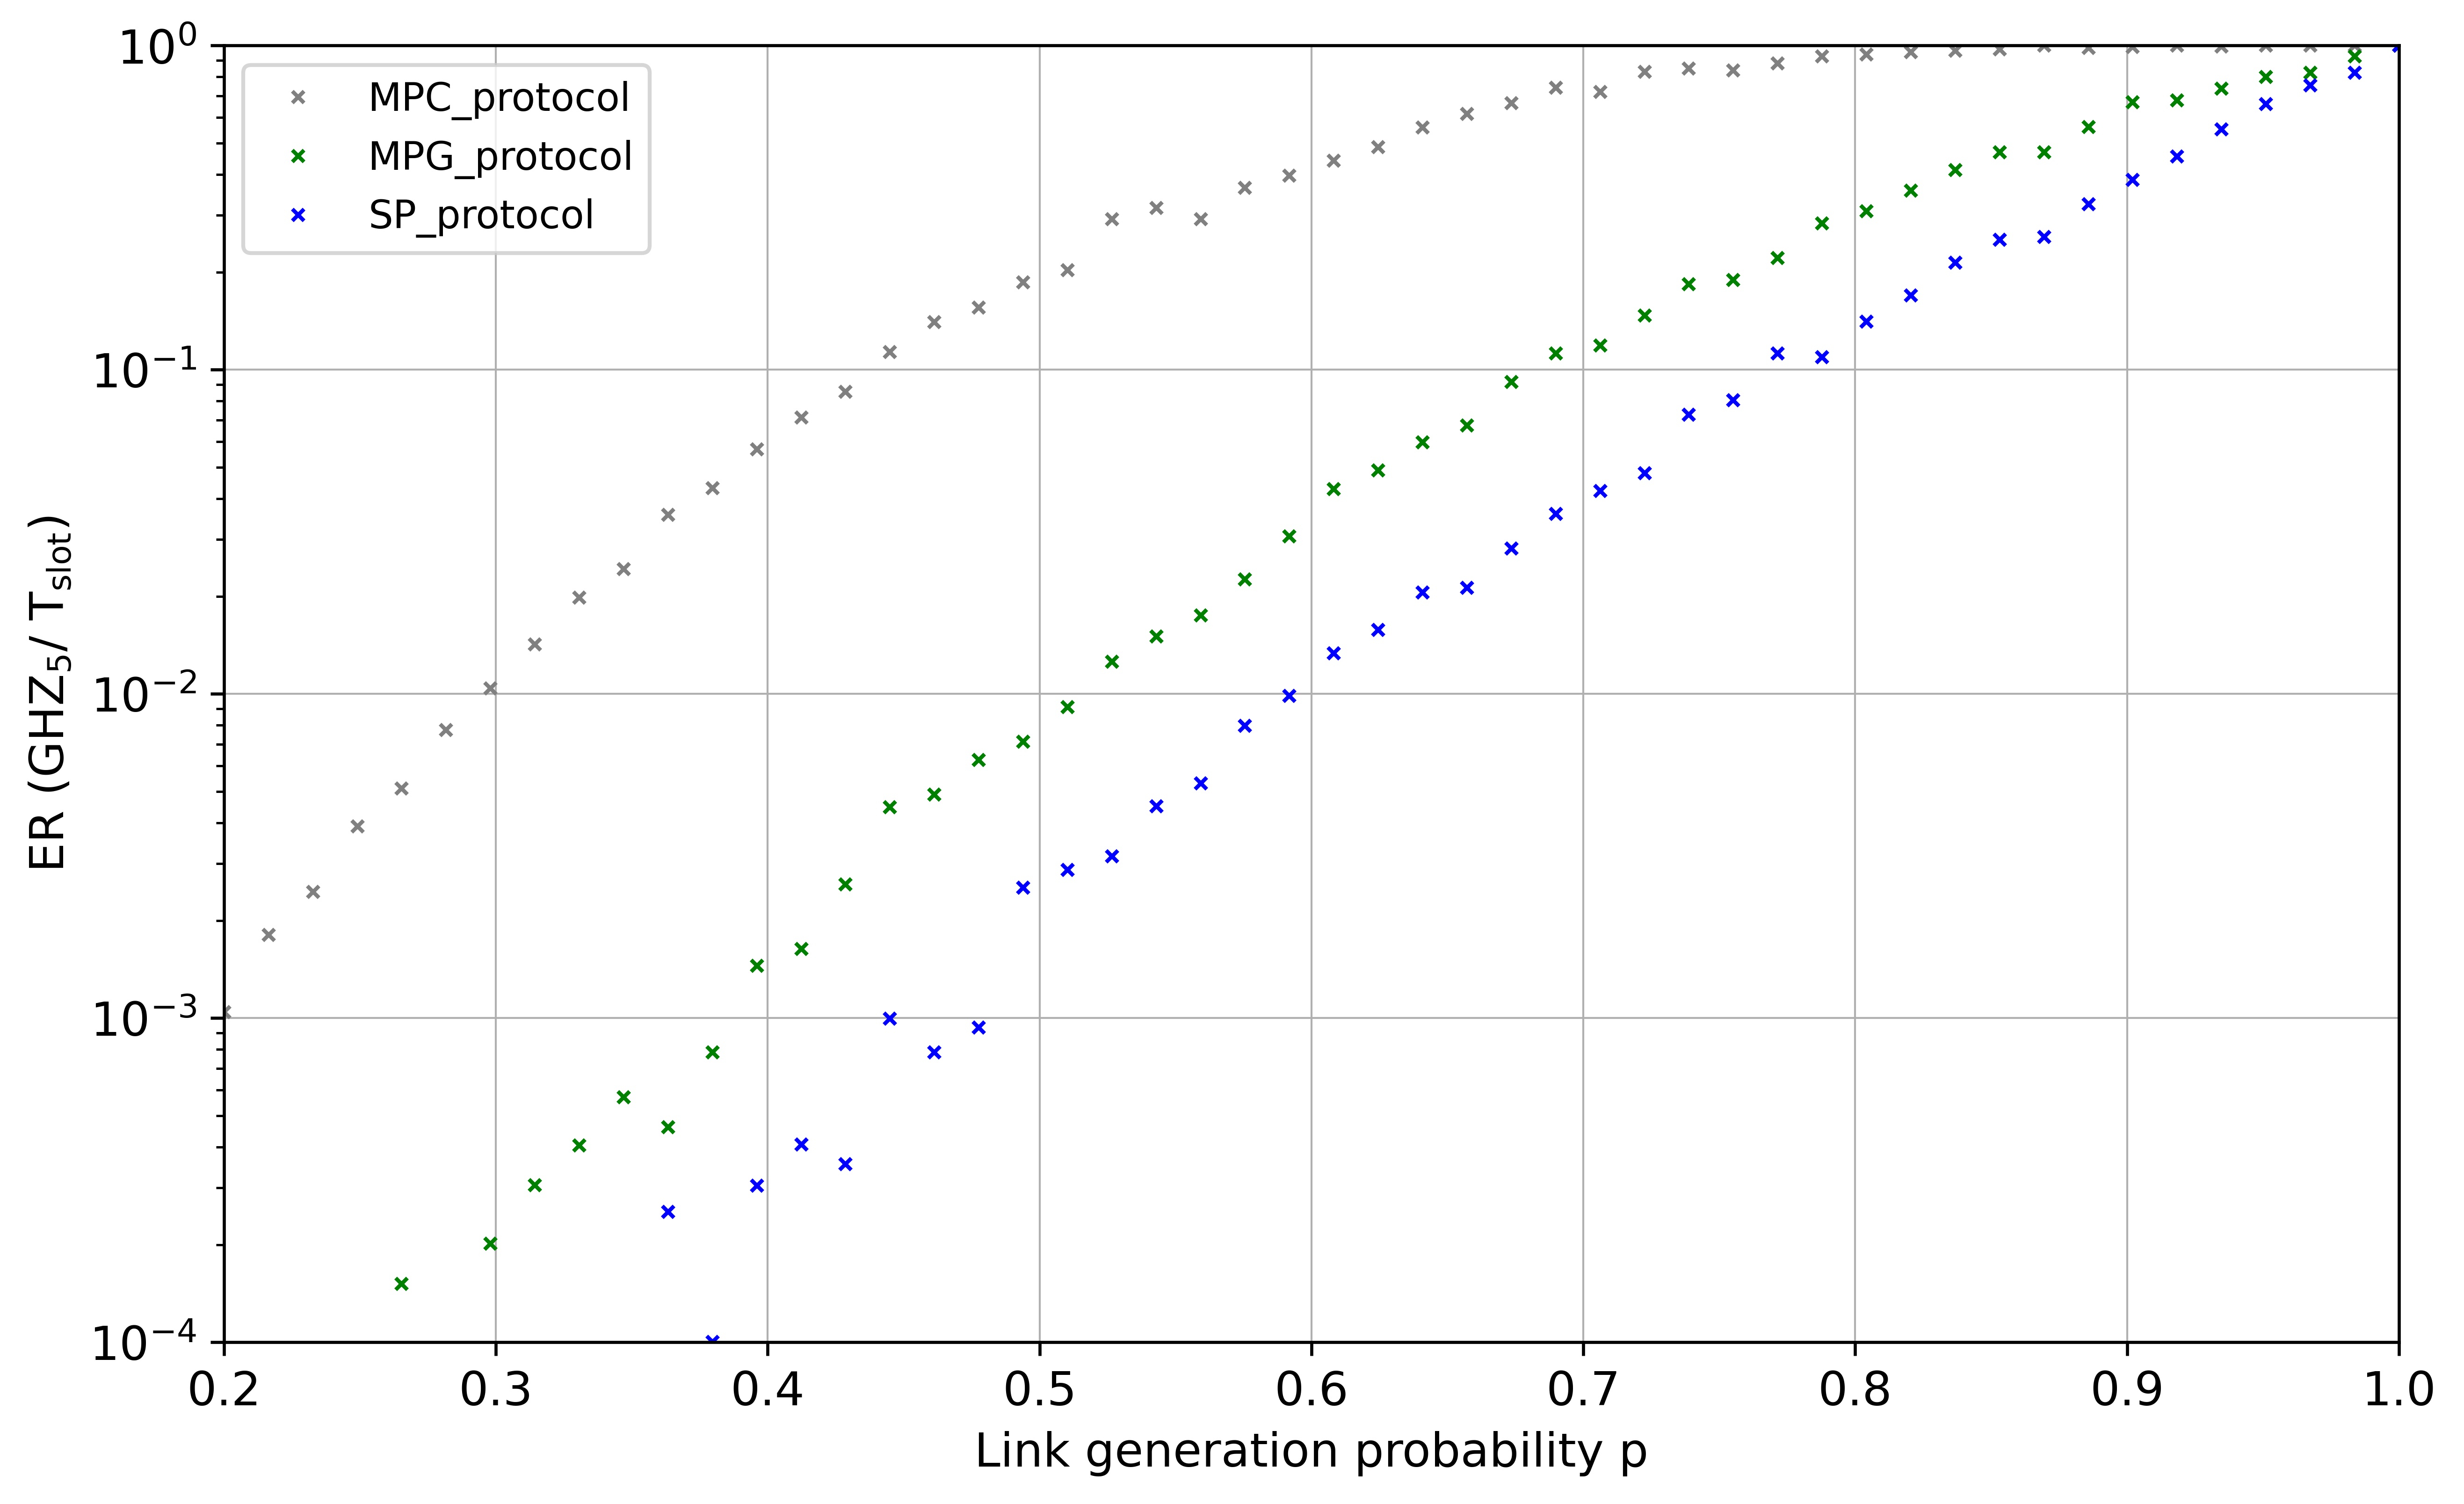

: 

In [ ]:
# ============== 2) 全局参数 ==============
funcs = [MPC_protocol, MPG_protocol, SP_protocol]
p_range = np.linspace(1, 0.2, 50)

timesteps = 100
reps = 200
alpha = 1.4
beta = 0.105
max_rounds = 10
shuffle_nodes = True

sr_results = []  # 每个文件的 SR 结果都会追加到这里

# 分段退出：针对“组合”数量
chunk_size = 300 
state_file = "loop_state.pkl"

# ============== 3) 读取/初始化进度 ==============
try:
    with open(state_file, "rb") as f:
        progress = pickle.load(f)
    print("恢复进度：", progress)
except FileNotFoundError:
    progress = {
        "subfolder_idx": 0,   # 当前处理到第几个子文件夹
        "file_idx": 0,        # 当前子文件夹内处理到第几个文件
        "combo_idx": 0,       # 当前文件内处理到第几个组合
        "global_combo_count": 0  # 全局已处理的组合数
    }
    print("未发现进度文件，从头开始。")

# 子文件夹列表  
subfolders = [sf for sf in root_path.iterdir() if sf.is_dir()]
subfolders.sort()

# ============== 4) 主循环 ==============
for s_idx in range(progress["subfolder_idx"], len(subfolders)):
    subfolder = subfolders[s_idx]
    if not subfolder.is_dir():
        continue

    print(f"\nProcessing subfolder: {subfolder} ({s_idx+1}/{len(subfolders)})")

    # 遍历文件
    files = [f for f in subfolder.iterdir() if f.is_file()]
    files.sort()
    for f_idx in range(progress["file_idx"], len(files)):
        file = files[f_idx]
        if not file.is_file():
            continue

        print(f"  Processing file: {file} ({f_idx+1}/{len(files)}) ...")

        # 每个文件：初始化 counters
        failure_counts = {func.__name__: 0 for func in funcs}
        combination_counter = 0

        # 加载图
        G, users, pos = load_data(file)
        # nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray")
        # plt.close()

        G = network(G)

        # 输出路径
        class_folder = subfolder.name
        file_path = file.with_suffix(".png")
        file_name = file.stem

        er_folder_path = Path.cwd().parent.joinpath("new_result2", class_folder)
        er_folder_path.mkdir(exist_ok=True)
        er_topology_folder_path = er_folder_path.joinpath(file_name)
        er_topology_folder_path.mkdir(exist_ok=True)
        communities_output_path = Path.cwd().parent.joinpath("communitie", class_folder, file_name)


        # 运行社团划分并获得组合列表
        communities, users_node_combination = multi_iterative_score_partition_with_drawing(
            G, users[0], alpha, beta, max_rounds, shuffle_nodes, pos, communities_output_path
        )

        # 采样组合，这里从所有组合中随机采样 100 个
        sampled_combinations = np.random.choice(
            len(users_node_combination),
            size=min(100, len(users_node_combination)),
            replace=False
        )

                # ============ CSV 文件检查 ============
        # 目标 CSV 文件：每个文件对应一个 CSV，其中每一行代表一个组合的结果
        csv_path = er_topology_folder_path.joinpath(f"{file_name}_sr_details.csv")
        if csv_path.exists():
            with open(csv_path, "r", newline="") as csvfile:
                reader = csv.reader(csvfile)
                rows = list(reader)
                # 假设第一行是表头，所以有效数据行数为总行数-1
                data_rows = len(rows) - 1 if rows else 0

            if data_rows != len(sampled_combinations):
                print(f"文件 {file_name} CSV数据行数超过sampled_combinations (共 {data_rows} 行)，存在异常，重新处理该文件。")
                csv_path.unlink()  # 删除异常的 CSV 文件，重新跑一遍
            else:
                print(f"文件 {file_name} 已处理完成 (共 {data_rows} 条数据)，跳过该文件。")
                continue  # 文件已处理，无需重复跑
                
        # 用 tqdm 显示处理组合的进度
        for sampled_idx, original_idx in enumerate(tqdm(sampled_combinations, desc="  Processing combinations", unit="combo")):
            combo = users_node_combination[original_idx]
            combination_counter += 1
            progress["global_combo_count"] += 1

            # =========== 新增：组合详细信息 ===========
            combination_sr = {
                "Combination_ID": f"combo_{sampled_idx}",
                "Nodes": str(combo),  # 将节点列表转为字符串，如 "[2,5,9]"
            }

            # 计算 ER
            ER = np.zeros((len(funcs), len(p_range)))
            results = Parallel(n_jobs=-1, verbose=10)(
                delayed(process_single_p)(G, combo, p, funcs, timesteps, reps)
                for p in p_range
            )

            # 将结果填充到 ER 矩阵
            for i, p_ers in enumerate(results):
                ER[:, i] = p_ers

            plot_er_vs_p(p_range, ER, funcs, cols, er_topology_folder_path.joinpath(f'result_for_{str(combo)}'))

            # =========== 计算成功率比例 ===========
            for func_idx, func in enumerate(funcs):
                protocol_er = ER[func_idx, :]
                zero_count = np.sum(protocol_er < 1e-10)
                success_ratio = 1 - (zero_count / len(p_range))  # 计算成功率比例
                combination_sr[func.__name__] = round(success_ratio, 3)  # 保留3位小数

            del results, ER
            gc.collect()

            # =========== 写入CSV文件 ===========
            output_subfolder_csv_path = er_topology_folder_path.joinpath(f"{file.stem}_sr_details.csv")
            fieldnames = ["Combination_ID", "Nodes"] + [func.__name__ for func in funcs]
            write_header = not output_subfolder_csv_path.exists()

            with open(output_subfolder_csv_path, mode="a", newline="") as subfile:
                csv_writer = csv.DictWriter(subfile, fieldnames=fieldnames)
                if write_header:
                    csv_writer.writeheader()
                csv_writer.writerow(combination_sr)

            # 更新进度信息（写进度文件）
            progress["combo_idx"] = sampled_idx + 1
            progress["subfolder_idx"] = s_idx
            progress["file_idx"] = f_idx
            with open(state_file, "wb") as pf:
                pickle.dump(progress, pf)

            # 分段退出：每处理 chunk_size 个组合后退出
            if progress["global_combo_count"] % chunk_size == 0:
                print(f"\n已处理 {progress['global_combo_count']} 个组合，准备退出。")
                with open(state_file, "wb") as pf:
                    pickle.dump(progress, pf)
                exit()

        # 这个文件处理完 => 重置 combo_idx，并 file_idx+1
        progress["combo_idx"] = 0
        progress["file_idx"] = f_idx + 1
        with open(state_file, "wb") as pf:
            pickle.dump(progress, pf)
